# Prediction of bile predicaments

In [1]:
import pandas as pd

import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf

from sklearn.model_selection import train_test_split

import tensorflow_decision_forests as tfdf

import dtreeviz

from matplotlib import pyplot as plt
from IPython import display

# avoid "Arial font not found warnings"
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

display.set_matplotlib_formats('retina') # generate hires plots

np.random.seed(1234)  # reproducible plots_data for explanatory reasons

2023-11-20 02:26:36.366451: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 02:26:36.390201: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 02:26:36.390222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 02:26:36.391060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 02:26:36.395455: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 02:26:36.396210: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Get & clean data

### Load and inspect

In [2]:
df_idc = pd.read_excel("data/Intraductal_concrement.xlsx", sheet_name=0, skiprows=1, header=None)
df_idc_visits = pd.read_excel("data/Intraductal_concrement.xlsx", sheet_name=0, skiprows=0, header=None)
df_idc.columns = df_idc_visits.iloc[0] + '_' + df_idc.iloc[0]
df_idc.columns = df_idc.columns.str.lower()
df_idc.insert(2, 'has_idc', "1")
df_idc.drop(index=0, inplace=True)

In [3]:
df_idc.iloc[:, 2:]

,has_idc,baseline_characteristics_etiology,baseline_characteristics_admission_date,baseline_characteristics_age,baseline_characteristics_sex,baseline_characteristics_height_in_cm,baseline_characteristics_weight_in_kg,baseline_characteristics_bmi,baseline_characteristics_medical_history,baseline_characteristics_medication_at_admission,...,abdominal_sonography_size_of_smallest_concrement,abdominal_sonography_size_of_biggest_concrement,abdominal_sonography_ultrasound_behaviour,eus_ercp_mrcp_or_as_dhc_width_in_mm,NaN,eus_ercp_mrcp_or_as_intrahepatic_bile_duct_width_in_mm,NaN,NaN,ct/mri_date,ct/mri_special_report?
1,1,biliary,2012-04-07 00:00:00,91,f,unknown,unknown,unknown,"1,4,5,9","1,2,4",...,NaN,NaN,NaN,8,EUS,NaN,NaN,CT,2012-04-07 00:00:00,peripancreatic_fluid
2,1,biliary,2010-05-18 00:00:00,68,f,176,74,23.9,5,0,...,NaN,NaN,NaN,15,ERCP,NaN,NaN,NaN,NaN,NaN
3,1,biliary,2006-10-15 00:00:00,72,f,160,72,28.1,"1,4,7,9","1,2,3,4",...,NaN,NaN,NaN,15,CT,NaN,NaN,CT,2006-10-16 00:00:00,no_concrements
4,1,biliary,2006-10-01 00:00:00,66,f,165,52,19.1,"1,3,9","1,2,4,8",...,NaN,NaN,NaN,15,ERCP,NaN,NaN,NaN,NaN,NaN
5,1,biliary,2021-02-08 00:00:00,81,f,172,74,25,1.9,2.7,...,NaN,NaN,NaN,12,AS,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1,biliary,2006-04-28 00:00:00,69,m,169,75,26.3,"3,4,7,8,9",1.2,...,NaN,2.5,hyperechoic_with_acoustic_shadowing,8,AS,NaN,NaN,CT,2006-04-28 00:00:00,perpancreatic_fluid;no_concrements
164,1,biliary,2018-10-29 00:00:00,65,f,161,73,28.2,0,0,...,NaN,6,hyperechoic_with_acoustic_shadowing,9.5,EUS,NaN,NaN,CT,2018-10-29 00:00:00,GB:_41x27mm_concrement+15-20_concrements_about...
165,1,biliary,2017-12-01 00:00:00,60,m,176,115,37.1,9,1.2,...,NaN,5,unknown,11,AS,NaN,NaN,CT,2017-12-02 00:00:00,2_small_concrements_in_GB;peripancreatic_fluid
166,1,biliary,2018-12-29 00:00:00,54,f,156,81,33.3,9,unknown,...,unknown,unknown,unknown,unknown,NaN,NaN,NaN,CT,2018-12-30 00:00:00,concrements_and_sludge_in_DHC


In [4]:
df_idc.columns.tolist()[:10]

['baseline_characteristics_patient_number',
 'baseline_characteristics_case',
 'has_idc',
 'baseline_characteristics_etiology',
 'baseline_characteristics_admission_date',
 'baseline_characteristics_age',
 'baseline_characteristics_sex',
 'baseline_characteristics_height_in_cm',
 'baseline_characteristics_weight_in_kg',
 'baseline_characteristics_bmi']

In [5]:
df_no_idc = pd.read_excel("data/No_intraductal_concrement.xlsx", sheet_name=0, skiprows=1, header=None)
df_no_idc_visits = pd.read_excel("data/No_intraductal_concrement.xlsx", sheet_name=0, skiprows=0, header=None)
df_no_idc.columns = df_no_idc_visits.iloc[0] + '_' + df_no_idc.iloc[0]
df_no_idc.columns = df_no_idc.columns.str.lower()
df_no_idc.insert(2, 'has_idc', "0")
df_no_idc.drop(index=0, inplace=True)

In [6]:
df_no_idc.iloc[:, 2:]

,has_idc,baseline_characteristics_etiology,baseline_characteristics_admission_date,baseline_characteristics_age,baseline_characteristics_sex,baseline_characteristics_height_in_cm,baseline_characteristics_weight_in_kg,baseline_characteristics_bmi,baseline_characteristics_medical_history,baseline_characteristics_medication_at_admission,...,abdominal_sonography_size_of_smallest_concrement,abdominal_sonography_size_of_biggest_concrement,abdominal_sonography_ultrasound_behaviour,eus_ercp_mrcp_or_as_dhc_width_in_mm,NaN,eus_ercp_mrcp_or_as_intrahepatic_bile_duct_width_in_mm,NaN,NaN,ct/mri_date,ct/mri_special_report?
1,0,biliary,2006-11-21 00:00:00,69,m,177,76,24.3,8,0,...,unknown,unknown,hyperechoic_with_acoustic_shadowing,unknown,NaN,NaN,NaN,CT,2006-11-21 00:00:00,"2-3_concrements_(ca.0,6cm)_in_the_GB"
2,0,biliary,2017-07-23 00:00:00,81,f,160,84.6,33.2,9,"1,2,8",...,NaN,16,hyperechoic_with_acoustic_shadowing,9,EUS,NaN,NaN,NaN,NaN,NaN
3,0,biliary,2006-05-14 00:00:00,67,f,166,70,25.4,2.5,0,...,22,30,hyperechoic_with_acoustic_shadowing,10,CT,NaN,NaN,CT,2006-05-14 00:00:00,concrements_in_the_GB;peripancreatic_adipose_t...
4,0,biliary,2016-01-21 00:00:00,80,m,165,70,25.7,"1,4,7,9","1,2,3",...,NaN,NaN,NaN,13,ERCP,NaN,NaN,CT,2016-01-21 00:00:00,"prepapillary_concrement_ca.8,5mm"
5,0,biliary,2020-12-25 00:00:00,87,f,163,86,32.4,"4,5,8,9","1,2,3,4",...,unknown,unknown,unknown,unknown,NaN,NaN,NaN,CT,2020-12-30 00:00:00,GB_not_mentioned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0,biliary,2013-04-29 00:00:00,43,m,183,93,27.8,5,1,...,NaN,6,unknown,5,AS,NaN,NaN,CT,2013-04-29 00:00:00,no_concrements
178,0,biliary,2012-01-22 00:00:00,83,m,180,85,26.2,9,2.3,...,unknown,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN
179,0,biliary,2018-08-24 00:00:00,55,f,161,66.3,25.6,0,1.2,...,unknown,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN
180,0,biliary,2011-12-23 00:00:00,49,m,180,86,26.5,0,0,...,unknown,unknown,hyperechoic_with_acoustic_shadowing,15,MRCP,NaN,NaN,NaN,NaN,NaN


In [7]:
df_no_idc.columns.tolist()[:10]

['baseline_characteristics_patient_number',
 'baseline_characteristics_case',
 'has_idc',
 'baseline_characteristics_etiology',
 'baseline_characteristics_admission_date',
 'baseline_characteristics_age',
 'baseline_characteristics_sex',
 'baseline_characteristics_height_in_cm',
 'baseline_characteristics_weight_in_kg',
 'baseline_characteristics_bmi']

### Check that column names are identical

In [8]:
assert(df_idc.columns.tolist() == df_no_idc.columns.tolist())

### Join the data frames

In [9]:
input_data = pd.concat([df_idc, df_no_idc])

### Clean and format

In [10]:
input_data.replace(['unknown', 'missing', 'ns', ' ns', "ms", "s", "sn"], np.nan, inplace=True)
lab_cols = input_data.filter(like='lab_values').columns
input_data[lab_cols] = input_data[lab_cols].replace(',', '.', regex=True)
input_data[lab_cols] = input_data[lab_cols].replace(['.*\\.\\..*', '.*\\.\\.\\..*'], pd.NA, regex=True)
input_data[lab_cols] = input_data[lab_cols].replace('ß', '0', regex=True)
input_data[lab_cols] = input_data[lab_cols].replace('.', np.nan)
input_data[lab_cols] = input_data[lab_cols].replace('n2.23', np.nan)

In [11]:
input_data[['ercp_date', 'baseline_characteristics_admission_date']] = input_data[['ercp_date', 'baseline_characteristics_admission_date']].replace(['.*\\.\\..*', '.*\\.\\.\\..*'], pd.NA, regex=True)

input_data = input_data.convert_dtypes()
input_data[lab_cols] = input_data[lab_cols].astype('float64')

# Add column if ercp_date was within 3 days of admission baseline_characteristics_admission_date
input_data['ercp_date'] = pd.to_datetime(input_data['ercp_date'])
input_data['baseline_characteristics_admission_date'] = pd.to_datetime(input_data['baseline_characteristics_admission_date'])
input_data['ercp_date_minus_admission_date'] = input_data['ercp_date'] - input_data['baseline_characteristics_admission_date']
input_data['ecrp_gte_3_days_naT'] = input_data['ercp_date_minus_admission_date'] >= pd.Timedelta(days=3) 
input_data['ercp_date_na'] = input_data['ercp_date'].isna()
input_data['ecrp_gte_3_days'] =  input_data['ercp_date_na'] | input_data['ecrp_gte_3_days_naT']

# Rename column names of input_data
input_data.columns = input_data.columns.str.replace('/', '_')
input_data.columns = input_data.columns.str.replace(' ', '')

In [12]:

input_data.iloc[:, 2:]

,has_idc,baseline_characteristics_etiology,baseline_characteristics_admission_date,baseline_characteristics_age,baseline_characteristics_sex,baseline_characteristics_height_in_cm,baseline_characteristics_weight_in_kg,baseline_characteristics_bmi,baseline_characteristics_medical_history,baseline_characteristics_medication_at_admission,...,NaN,eus_ercp_mrcp_or_as_intrahepatic_bile_duct_width_in_mm,NaN,NaN,ct_mri_date,ct_mri_special_report?,ercp_date_minus_admission_date,ecrp_gte_3_days_naT,ercp_date_na,ecrp_gte_3_days
1,1,biliary,2012-04-07,91,f,<NA>,NaN,<NA>,"1,4,5,9","1,2,4",...,EUS,<NA>,<NA>,CT,2012-04-07 00:00:00,peripancreatic_fluid,13 days,True,False,True
2,1,biliary,2010-05-18,68,f,176,74,23.9,5,0,...,ERCP,<NA>,<NA>,<NA>,NaN,<NA>,0 days,False,False,False
3,1,biliary,2006-10-15,72,f,160,72,28.1,"1,4,7,9","1,2,3,4",...,CT,<NA>,<NA>,CT,2006-10-16 00:00:00,no_concrements,2 days,False,False,False
4,1,biliary,2006-10-01,66,f,165,52,19.1,"1,3,9","1,2,4,8",...,ERCP,<NA>,<NA>,<NA>,NaN,<NA>,2 days,False,False,False
5,1,biliary,2021-02-08,81,f,172,74,25.0,1.9,2.7,...,AS,<NA>,<NA>,<NA>,NaN,<NA>,1 days,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0,biliary,2013-04-29,43,m,183,93,27.8,5,1,...,AS,<NA>,<NA>,CT,2013-04-29 00:00:00,no_concrements,NaT,False,True,True
178,0,biliary,2012-01-22,83,m,180,85,26.2,9,2.3,...,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,NaT,False,True,True
179,0,biliary,2018-08-24,55,f,161,66.3,25.6,0,1.2,...,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,NaT,False,True,True
180,0,biliary,2011-12-23,49,m,180,86,26.5,0,0,...,MRCP,<NA>,<NA>,<NA>,NaN,<NA>,NaT,False,True,True


### Write data to csv for external analysis

In [13]:
input_data_tab1 = input_data.copy()
input_data_tab1.loc[:, 'has_idc'] = input_data_tab1['has_idc'].astype('category')
input_data_tab1.to_csv("data/input_data_tab1.csv", index=False)

## Prepare data for TFDF: BASELINE

### Features

In [14]:
TARGET_COLUMN_NAME = ["has_idc"]

ECRP_GTE_3_DAYS = ["ecrp_gte_3_days"]

DATA_HEADER = input_data.columns

CATEGORICAL_FEATURE_NAMES = [
                            'baseline_characteristics_sex', 
                            'baseline_characteristics_nicotine_use',
                            #'baseline_characteristics_alcohol_use',
                            ]

NUMERIC_BASELINE_FEATURE_NAMES = [
                            'baseline_characteristics_age',
                            'baseline_characteristics_height_in_cm',
                            'baseline_characteristics_weight_in_kg',
                            # 'baseline_characteristics_bmi',
                             #'eus_ercp_mrcp_or_as_dhc_width_in_mm'
                            ]

# NUMERIC_LAB_FEATURE_NAMES_ADMISSION = input_data.filter(like='lab_values_admission').columns.tolist()
# Remove variables with mostly missing values
NUMERIC_LAB_FEATURE_NAMES_ADMISSION =['lab_values_admission_crp_in_mg_dl',
                                    #'lab_values_admission_pct_in_ng_ml',
                                    #'lab_values_admission_il6_in_pg_ml',
                                    'lab_values_admission_leukocytes_in_g_l',
                                    'lab_values_admission_bilirubin_in_mg_dl',
                                    'lab_values_admission_got_ast_in_u_l',
                                    #'lab_values_admission_gpt_alt_in_u_l',
                                    'lab_values_admission_gamma-gt_in_u_l',
                                    'lab_values_admission_alkaline_phosphatase_in_u_l',
                                    #'lab_values_admission_lipase_in_u_l',
                                    #'lab_values_admission_inr',
                                    # 'lab_values_admission_quick _in_%',
                                    'lab_values_admission_calcium_in_mmol_l',
                                    # 'lab_values_admission_calcium_alb.-corrected_mmol_l',
                                    # 'lab_values_admission_triglycerides_in_mg_dl',
                                    'lab_values_admission_hematocrit',
                                    #'lab_values_admission_gfr_in_ml_min',
                                    'lab_values_admission_creatinine_in_mg_dl',
                                    #'lab_values_admission_urea_in_mg_dl',
                                    #'lab_values_admission_igg4_in_g_l'
                                    ]
# Fix names for use in model

# NUMERIC_LAB_FEATURE_NAMES_DAY3 = input_data.filter(like='lab_values_day_3').columns.tolist()

NUMERIC_LAB_FEATURE_NAMES_DAY3 = ['lab_values_day_3_crp_in_mg_dl',
                                #'lab_values_day_3_pct_in_ng_ml',
                                #'lab_values_day_3_il6_in_pg_ml',
                                #'lab_values_day_3_leukocytes_in_g_l',
                                'lab_values_day_3_bilirubin_in_mg_dl',
                                'lab_values_day_3_got_ast_in_u_l',
                                #'lab_values_day_3_gpt_alt_in_u_l',
                                'lab_values_day_3_gamma-gt_in_u_l',
                                'lab_values_day_3_alkaline_phosphatase_in_u_l',
                                #'lab_values_day_3_lipase_in_u_l',
                                #'lab_values_day_3_inr',
                                #'lab_values_day_3_quick _in_%',
                                #'lab_values_day_3_calcium_in_mmol_l',
                                #'lab_values_day_3_calcium_alb.-corrected_mmol_l',
                                #'lab_values_day_3_triglycerides_in_mg_dl',
                                'lab_values_day_3_hematocrit',
                                #'lab_values_day_3_gfr_in_ml_min',
                                #'lab_values_day_3_creatinine_in_mg_dl',
                                #'lab_values_day_3_urea_in_mg_dl'
                                ]

NUMERIC_FEATURE_NAMES_ALL = NUMERIC_BASELINE_FEATURE_NAMES + NUMERIC_LAB_FEATURE_NAMES_ADMISSION + NUMERIC_LAB_FEATURE_NAMES_DAY3
ALL_FEATURE_NAMES_ADMISSION = TARGET_COLUMN_NAME + CATEGORICAL_FEATURE_NAMES + NUMERIC_BASELINE_FEATURE_NAMES + NUMERIC_LAB_FEATURE_NAMES_ADMISSION
ALL_FEATURE_NAMES_DAY3 = TARGET_COLUMN_NAME + CATEGORICAL_FEATURE_NAMES + NUMERIC_BASELINE_FEATURE_NAMES + NUMERIC_LAB_FEATURE_NAMES_DAY3

### Select and convert data types

In [15]:
x_data = pd.DataFrame()

x_data_pre = input_data.copy()

x_data[TARGET_COLUMN_NAME] = x_data_pre[TARGET_COLUMN_NAME].astype('int')

x_data[CATEGORICAL_FEATURE_NAMES] = x_data_pre[CATEGORICAL_FEATURE_NAMES].fillna('').astype('category')
if len(CATEGORICAL_FEATURE_NAMES) > 0:
    x_data[CATEGORICAL_FEATURE_NAMES] = x_data[CATEGORICAL_FEATURE_NAMES].apply(lambda x: x.cat.codes).astype('int64')

x_data[NUMERIC_FEATURE_NAMES_ALL]= x_data_pre[NUMERIC_FEATURE_NAMES_ALL].fillna(float(np.nan)).astype('float64')

x_data[ECRP_GTE_3_DAYS] = x_data_pre[ECRP_GTE_3_DAYS].astype('bool')

x_data['dhc_in_mm'] = x_data_pre['eus_ercp_mrcp_or_as_dhc_width_in_mm']

x_data.dtypes

has_idc                                               int64
baseline_characteristics_sex                          int64
baseline_characteristics_nicotine_use                 int64
baseline_characteristics_age                        float64
baseline_characteristics_height_in_cm               float64
baseline_characteristics_weight_in_kg               float64
lab_values_admission_crp_in_mg_dl                   float64
lab_values_admission_leukocytes_in_g_l              float64
lab_values_admission_bilirubin_in_mg_dl             float64
lab_values_admission_got_ast_in_u_l                 float64
lab_values_admission_gamma-gt_in_u_l                float64
lab_values_admission_alkaline_phosphatase_in_u_l    float64
lab_values_admission_calcium_in_mmol_l              float64
lab_values_admission_hematocrit                     float64
lab_values_admission_creatinine_in_mg_dl            float64
lab_values_day_3_crp_in_mg_dl                       float64
lab_values_day_3_bilirubin_in_mg_dl     

### Split data in training and test data

In [16]:
train_df, test_df = train_test_split(x_data, test_size=0.2, random_state=42)

test_df_ecrp_gte_3_days = test_df[ECRP_GTE_3_DAYS]

test_df_pandas = test_df.copy()

# remove pass_dhc_col from test_df
test_df = test_df.drop(columns=['dhc_in_mm'])
train_df = train_df.drop(columns=['dhc_in_mm'])

test_df_copy = test_df.copy()


test_labels = test_df_copy[TARGET_COLUMN_NAME].values
test_df_d3 = test_df_copy[ALL_FEATURE_NAMES_DAY3]
test_df_d3.columns = test_df_d3.columns.str.replace('baseline_characteristics_', '')
test_df_d3.columns = test_df_d3.columns.str.replace('lab_values_day_3_', '')
model_cols = test_df_d3.columns
test_df_d32 = test_df_d3.copy()



### Write model columns to csv

In [17]:
model_cols_df = pd.DataFrame()
model_cols_df['model_cols'] = model_cols
model_cols_df['dtypes'] = test_df_d32.dtypes.astype('str').tolist()

# Write to csv
model_cols_df.to_csv("data/model_cols_df.csv", index=False)

#### Make train tf-dataset

In [18]:
train_df = train_df[ALL_FEATURE_NAMES_ADMISSION]
train_df.columns = train_df.columns.str.replace('baseline_characteristics_', '')
train_df.columns = train_df.columns.str.replace('lab_values_admission_', '')
train_df = train_df[model_cols]

train_df.dtypes

has_idc                          int64
sex                              int64
nicotine_use                     int64
age                            float64
height_in_cm                   float64
weight_in_kg                   float64
crp_in_mg_dl                   float64
bilirubin_in_mg_dl             float64
got_ast_in_u_l                 float64
gamma-gt_in_u_l                float64
alkaline_phosphatase_in_u_l    float64
hematocrit                     float64
dtype: object

In [19]:

# Impute training data
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(train_df)
df_imputed = pd.DataFrame(imputed, columns=train_df.columns)

df_imputed['has_idc'] = df_imputed['has_idc'].astype('int64')

train_df_pd = df_imputed.copy()

train_df = tfdf.keras.pd_dataframe_to_tf_dataset(df_imputed, label="has_idc")

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


#### Make test tf-dataset

In [20]:
test_labels = test_df[TARGET_COLUMN_NAME].values
test_df = test_df[ALL_FEATURE_NAMES_ADMISSION]
test_df.columns = test_df.columns.str.replace('baseline_characteristics_', '')
test_df.columns = test_df.columns.str.replace('lab_values_admission_', '')
test_df = test_df[model_cols]
test_df = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="has_idc")

## Train the model - random forests BASELINE

In [21]:
# Crete a tuner for model optimization on sensitivity (i.e. has_idc=1)

# model_rf = tfdf.keras.GradientBoostedTreesModel()
model_rf = tfdf.keras.RandomForestModel(
    #tuner=tuner
    )
model_rf.fit(train_df)

Use /tmp/tmp8x6n2a4j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.153446. Found 278 examples.
Training model...
Model trained in 0:00:00.073951
Compiling model...


[INFO 23-11-20 02:26:42.7135 UTC kernel.cc:1233] Loading model from path /tmp/tmp8x6n2a4j/model/ with prefix 0c087b8649674c6f
[INFO 23-11-20 02:26:42.7321 UTC decision_forest.cc:660] Model loaded with 300 root(s), 18946 node(s), and 11 input feature(s).
[INFO 23-11-20 02:26:42.7321 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-11-20 02:26:42.7321 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


### Evaluate the model

1/1 [==============================] - 0s 70ms/step


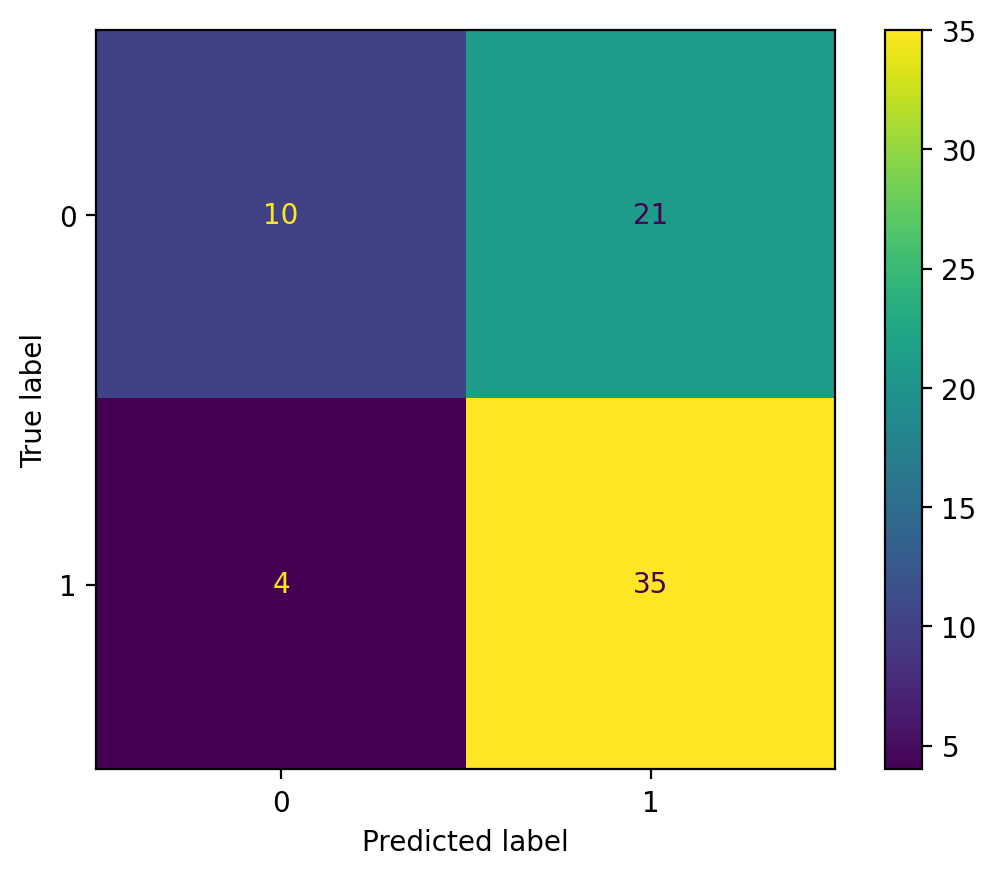

In [22]:
model_rf.compile(metrics=["accuracy", "AUC", "TruePositives", "TrueNegatives", "FalsePositives", "FalseNegatives"])

probs = model_rf.predict(test_df)
preds = probs > 0.25

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(test_labels, preds)

import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, preds)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

**Figure.** Confusion matrix for the test set: True positives (TP), true negatives (TN), false positives (FP), false negatives (FN).

In [23]:
# Write data for analysis in R to csv
test_df_pandas['pred_prob'] = probs
test_df_pandas['pred_idc'] = preds
test_df_pandas.to_csv("data/test_df_pandas.csv", index=False)

In [24]:
evaluation = model_rf.evaluate(test_df, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 662ms/step - loss: 0.0000e+00 - accuracy: 0.6857 - auc: 0.7560 - true_positives: 22.0000 - true_negatives: 26.0000 - false_positives: 5.0000 - false_negatives: 17.0000
loss: 0.0000
accuracy: 0.6857
auc: 0.7560
true_positives: 22.0000
true_negatives: 26.0000
false_positives: 5.0000
false_negatives: 17.0000


#### Inspect the model

In [25]:
print(model_rf.summary())

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (11):
	age
	alkaline_phosphatase_in_u_l
	bilirubin_in_mg_dl
	crp_in_mg_dl
	gamma-gt_in_u_l
	got_ast_in_u_l
	height_in_cm
	hematocrit
	nicotine_use
	sex
	weight_in_kg

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.             "gamma-gt_in_u_l"  0.262792 ################
    2.                         "age"  0.250733 ##############
    3. "alkaline_phosphatase_in_u_l"  0.196476 ########
    4.                "weight_in_kg"  0.186340 ######
    5.                "crp_in_mg_dl"  0.183736 ######
    6.                "height_in_cm"  0.182701 ######
    7.              "got_ast_in_u_l" 

#### Plot the model

In [26]:
# Tell dtreeviz about training data and model
model_features = [f.name for f in model_rf.make_inspector().features()]

model_features
classes = [0, 1]

train_df_pd['has_idc'] = train_df_pd['has_idc'].astype(int)

viz_cmodel = dtreeviz.model(model_rf,
                           tree_index=3,
                           X_train=train_df_pd[model_features],
                           y_train=train_df_pd['has_idc'],
                           feature_names=model_features,
                           target_name=TARGET_COLUMN_NAME,
                           class_names=classes)



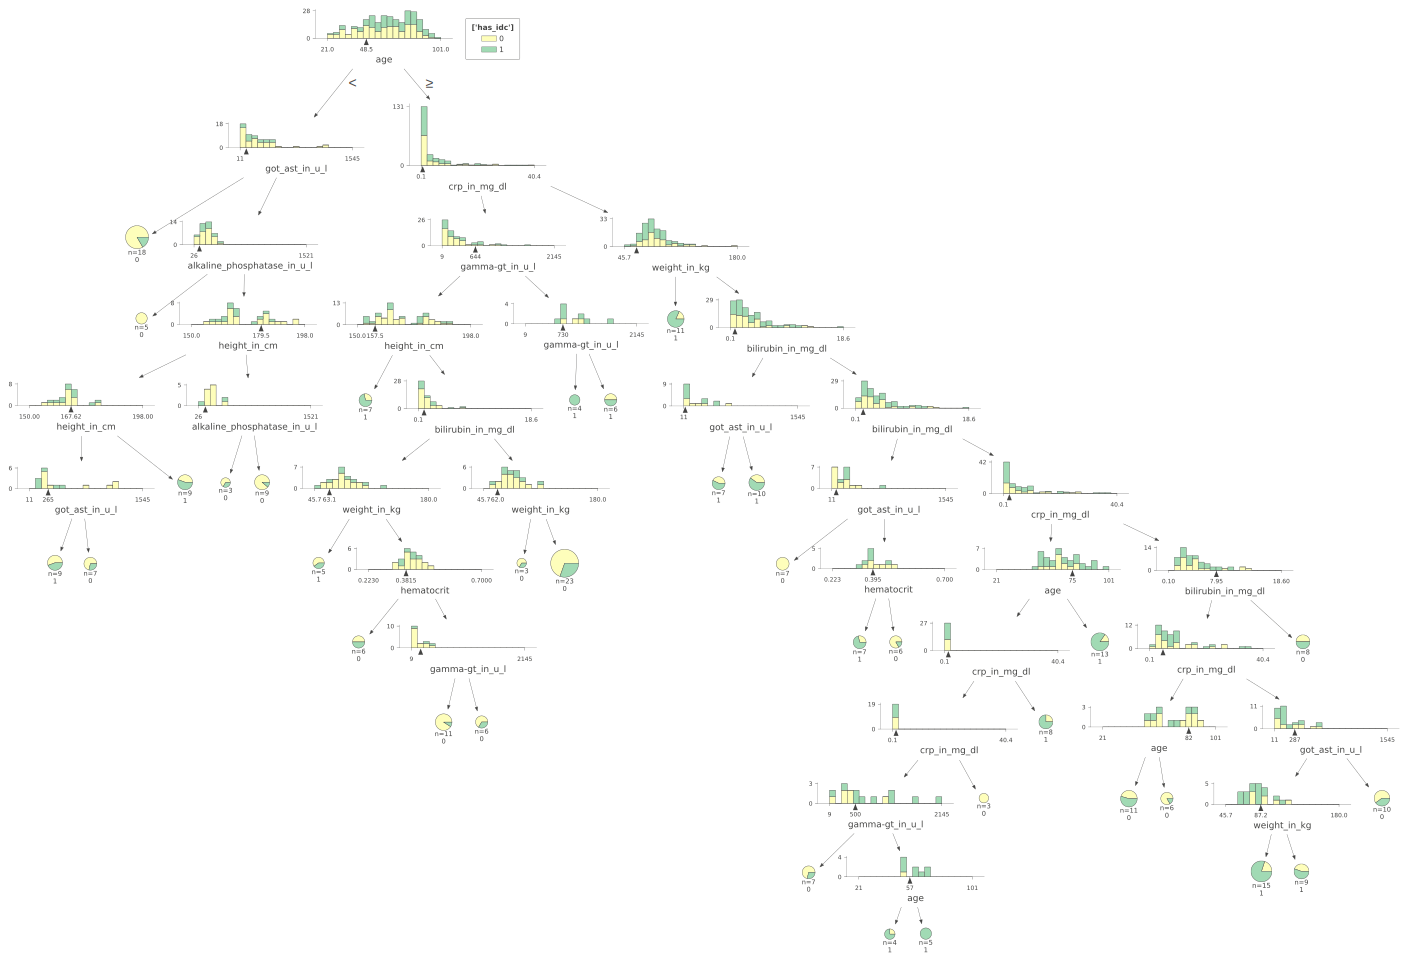

In [27]:
viz_cmodel.view()

/opt/conda/lib/python3.11/site-packages/dtreeviz/models/shadow_decision_tree.py:335: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/opt/conda/lib/python3.11/site-packages/dtreeviz/trees.py:1231: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


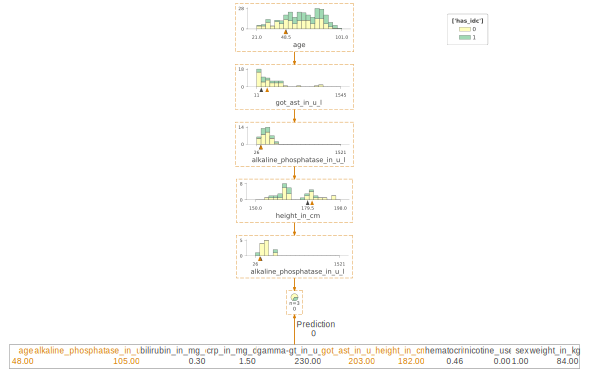

In [28]:
x = train_df_pd[model_features].iloc[0]
viz_cmodel.view(x=x, show_just_path=True, scale=.75)

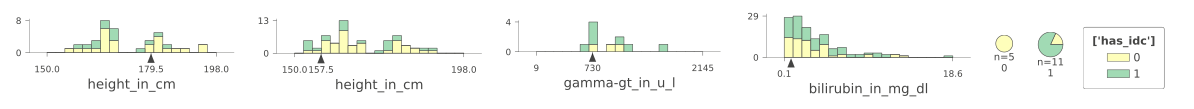

In [29]:
viz_cmodel.view(depth_range_to_display=[3,3], scale=1.5)

In [30]:
from io import open
plt_html = tfdf.model_plotter.plot_model(model_rf, tree_idx=0, max_depth=3)
with open('plt.html', 'w') as file:
    file.write(plt_html)
  


#### Plot the training logs

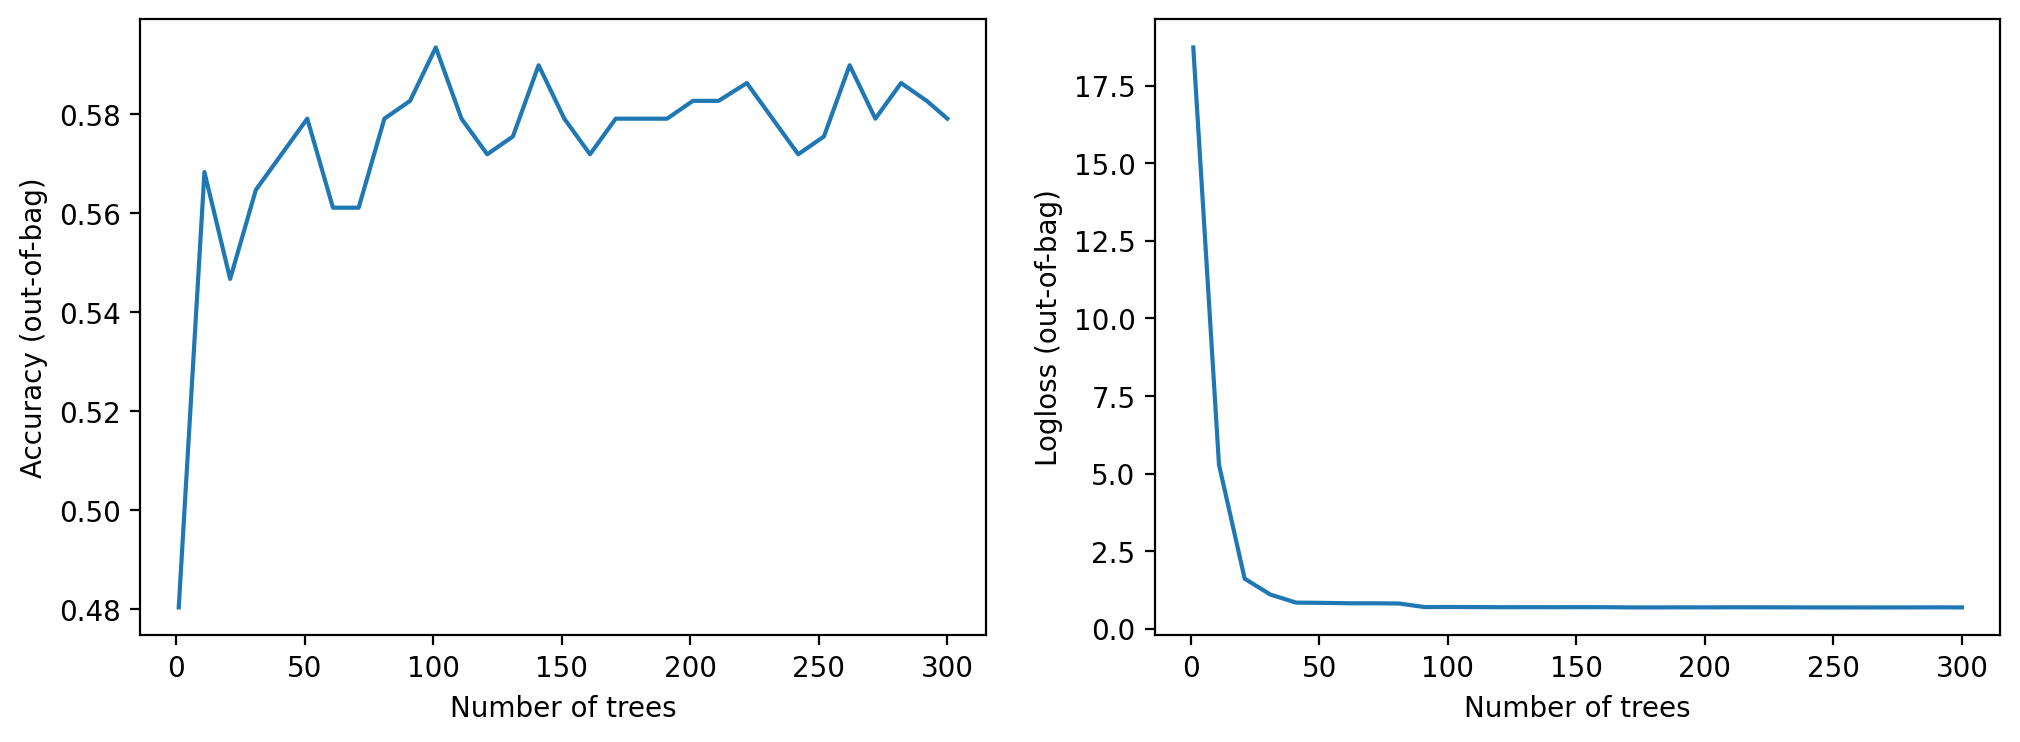

In [31]:
import matplotlib.pyplot as plt

logs = model_rf.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

## Test data for TFDF: Day 3

### Features

#### Test the model on day 3

In [32]:
test_df_ecrp_gte_3_days.values

array([[ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [

1/1 [==============================] - 0s 32ms/step


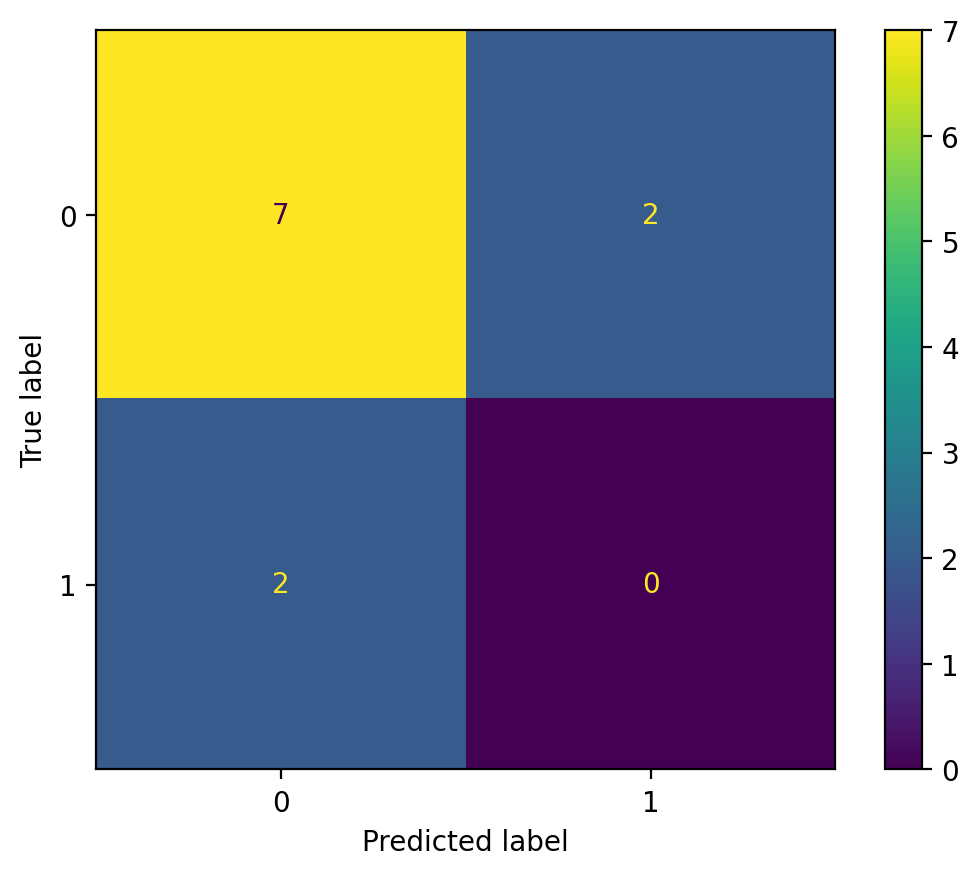

In [33]:
# Subset test_df_d3 for only preds == True and ecrp_gte_3_days == True
d3 = test_df_ecrp_gte_3_days.values
tp = (np.logical_and(d3 == True, preds == False))
test_df_d32_keras = tfdf.keras.pd_dataframe_to_tf_dataset(test_df_d32[tp], label="has_idc")


probs_d3 = model_rf.predict(test_df_d32_keras)

probs_d3 = probs_d3 > 0.3

probs_d3 = probs_d3.astype(int)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(test_labels[tp], probs_d3)




import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels[tp], probs_d3)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()


**Figure.** This figure shows the patients who did not receive an ERCP within 3 days of admission and who were classfied as 'no IDC' on admission. Note: the number of cases with IDC is very low!

In [34]:
evaluation = model_rf.evaluate(test_df_d32_keras, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 205ms/step - loss: 0.0000e+00 - accuracy: 0.8182 - auc: 0.4444 - true_positives: 0.0000e+00 - true_negatives: 9.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
loss: 0.0000
accuracy: 0.8182
auc: 0.4444
true_positives: 0.0000
true_negatives: 9.0000
false_positives: 0.0000
false_negatives: 2.0000
